In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import os
from src.utils.preprocess_utils import midi_to_multiclass_vectors
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics

In [2]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=50, tick_resolution=50):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.tick_resolution = tick_resolution
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_multiclass_vectors(file_path, tick_resolution=self.tick_resolution)
            
            if len(data) < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, len(data) - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = np.array(cropped_data[:-1]) # Input
            y = np.array(cropped_data[1:]) # "Label"

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset_sequence_length = 500
tick_resolution = 50
dataset = MidiDataset(data_dir='data/midis', sequence_length=dataset_sequence_length, tick_resolution=tick_resolution)

In [3]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [4]:
# Define model architecture
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(vocab_size, embedding_size)
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )
        self.output_projection = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, vocab_size]
        embedded = self.input_projection(x)  # [batch_size, sequence_length, embedding_size]
        transformer_out = self.transformer.encoder(embedded)  # [batch_size, sequence_length, embedding_size]
        output = self.output_projection(transformer_out)  # [batch_size, sequence_length, vocab_size]
        return output

vocab_size = 85  # Number of possible notes
embedding_size = 32  # Dimension of embedding vectors
num_heads = 4  # Number of attention heads
hidden_size = 128  # Size of feedforward layers in transformer
num_layers = 3  # Number of transformer encoder layers
dropout = 0.2  # Dropout rate

model = TransformerModel(vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout)

Error processing Beethoven, Ludwig van, Bagatelle, WoO 61a, OoLwAQrVQUY.mid: File Beethoven, Ludwig van, Bagatelle, WoO 61a, OoLwAQrVQUY.mid is too short for sequence length 500
Error processing Carr, Benjamin, The Analytical Instructor for the Piano Forte, bbu3W8AB33Q.mid: File Carr, Benjamin, The Analytical Instructor for the Piano Forte, bbu3W8AB33Q.mid is too short for sequence length 500
Error processing Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid: File Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid is too short for sequence length 500
Error processing Mozart, Wolfgang Amadeus, Fugue in F major, K.Anh.33, yy9SFM1PPYw.mid: File Mozart, Wolfgang Amadeus, Fugue in F major, K.Anh.33, yy9SFM1PPYw.mid is too short for sequence length 500
Error processing Parodi Ortega, Luis Félix, 12 Estudios para Piano, Op.49, dNDVDQ9KaYU.mid: File Parodi Ortega, Luis Félix, 12 Estudios para Piano, Op.49, dNDVDQ9KaYU.mid is too short for sequence length 500
Error proces

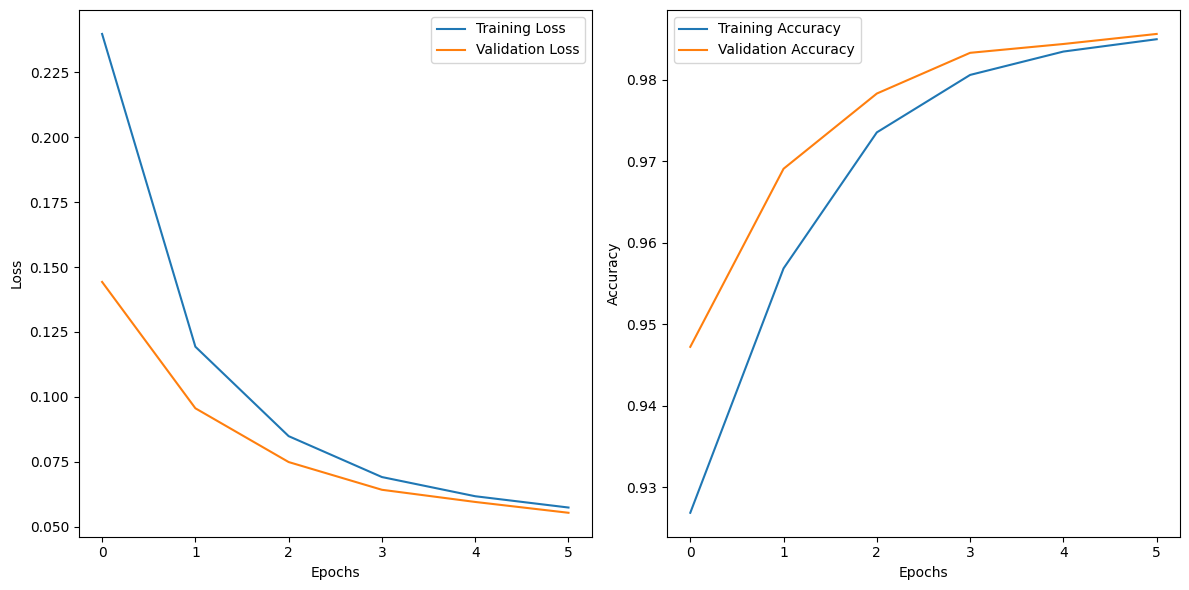

In [5]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multi-label",
    n_epochs=6,
    learning_rate=0.001,
    device="cuda"
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [6]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.BCEWithLogitsLoss(), task_type="multi-label", device="cuda")

Error processing Ernst, Philip, 20 Petites bagatelles agréables, fI2x2KxBuo4.mid: File Ernst, Philip, 20 Petites bagatelles agréables, fI2x2KxBuo4.mid is too short for sequence length 500
Error processing Gurlitt, Cornelius, Technik und Melodie, Op.228, PGCSoN1Hv6Y.mid: File Gurlitt, Cornelius, Technik und Melodie, Op.228, PGCSoN1Hv6Y.mid is too short for sequence length 500
Error processing Lyadov, Anatoly, 4 Preludes, Op.46, jZU6b05af3o.mid: File Lyadov, Anatoly, 4 Preludes, Op.46, jZU6b05af3o.mid is too short for sequence length 500
Error processing Gozenpud, Matvey, 8 Easy Etudes for Piano, pSxnHE1h9DM.mid: File Gozenpud, Matvey, 8 Easy Etudes for Piano, pSxnHE1h9DM.mid is too short for sequence length 500
Error processing Kunz, Konrad Max, 200 Short Two-Part Canons, Op.14, U2uqJvwjnsA.mid: File Kunz, Konrad Max, 200 Short Two-Part Canons, Op.14, U2uqJvwjnsA.mid is too short for sequence length 500
Error processing Satie, Erik, Allegro, 3yGYXvq-scc.mid: File Satie, Erik, Allegro, 3

(np.float64(0.054822378371860464), np.float64(0.985845687342625))

In [7]:
# Save model
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'weights/model_4/{timestamp}_e{embedding_size}_nh{num_heads}_h{hidden_size}_l{num_layers}_sl{dataset_sequence_length}_tr{tick_resolution}'

torch.save(best_model, filename)